In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns 
import plotly.express as px
from sklearn.decomposition import PCA
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.cm as cm

os.chdir("/net/trapnell/vol1/home/mdcolon/proj/morphseq")
from src.vae.auxiliary_scripts.assess_vae_results import assess_vae_results

from src.functions.embryo_df_performance_metrics import *


save_dir = "/net/trapnell/vol1/home/mdcolon/proj/morphseq/results/20250123"

model_index = 74
df_orig = pd.read_csv("/net/trapnell/vol1/home/nlammers/projects/data/morphseq/training_data/20241107_ds/SeqVAE_z100_ne150_sweep_01_block01_iter030/SeqVAE_training_2024-11-11_15-45-40/figures/embryo_stats_df.csv")

z_mu_columns = [col for col in df_orig.columns if 'z_mu' in col]    
z_mu_biological_columns = [col for col in z_mu_columns if "b" in col]

/net/trapnell/vol1/home/mdcolon/software/miniconda3/envs/vae_env_cluster/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/net/trapnell/vol1/home/mdcolon/software/miniconda3/envs/vae_env_cluster/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/11629321.1.trapnell-login.q/ipykernel_2190593/1123166587.py:20: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_orig = pd.read_csv("/net/trapnell/vol1/home/nlammers/projects/data/morphseq/training_data/20241107_ds/SeqVAE_z100_ne150_sweep_01_block01_iter030/SeqVAE_training_2024-11-11_15-45-40/figures/embryo_stats_df.csv"

In [2]:
import pandas as pd
from sklearn.decomposition import PCA

def apply_pca_on_pert_comparisons(
    df, 
    z_mu_biological_columns, 
    pert_comparisons=None, 
    n_components=3
):
    """
    Applies PCA on a subset of the DataFrame based on specified perturbations and adds PCA components
    to the same DataFrame (rows not in 'pert_comparisons' are removed).

    Parameters:
    - df (pd.DataFrame): The original DataFrame containing the data.
    - z_mu_biological_columns (list): List of column names in df to use for PCA.
    - pert_comparisons (iterable, optional): An iterable (e.g., list) of phenotypes to include in PCA.
                                             If None, all unique phenotypes are used.
    - n_components (int, optional): Number of PCA components to compute. Default is 3.

    Returns:
    - pd.DataFrame: The filtered DataFrame (rows matching 'pert_comparisons') with added PCA columns.
    """
    # Ensure necessary columns exist
    required_columns = ['phenotype'] + z_mu_biological_columns
    missing_columns = [col for col in required_columns if col not in df.columns]
    if missing_columns:
        raise ValueError(f"DataFrame is missing required columns: {missing_columns}")
    
    # Set pert_comparisons to all unique phenotypes if not provided
    if pert_comparisons is None:
        pert_comparisons = df['phenotype'].unique()
        print(f"No perturbations specified. Using all available phenotypes: {list(pert_comparisons)}")
    else:
        print(f"Using specified perturbations for PCA: {pert_comparisons}")

    # Filter the DataFrame based on 'pert_comparisons'
    df = df[df['phenotype'].isin(pert_comparisons)]
    
    # If no rows remain, raise an error
    if df.empty:
        raise ValueError("No data found for the specified perturbations in pert_comparisons.")
    
    # Extract the data for PCA
    X = df[z_mu_biological_columns].values
    
    # Handle missing values if any
    if pd.isnull(X).any():
        raise ValueError("Missing values detected in z_mu_biological_columns. "
                         "Please handle them before applying PCA.")
    
    # Apply PCA
    pca = PCA(n_components=n_components)
    pcs = pca.fit_transform(X)
    
    # Create PCA column names
    pca_columns = [f"PCA_{i+1}" for i in range(n_components)]
    
    # In-place assignment of PCA columns using a concise for loop
    # Initialize columns with NaN (optional) before assignment
    df.loc[:, pca_columns] = pd.NA
    
    for i, col in enumerate(pca_columns):
        df[col] = pcs[:, i]
    
    # Calculate Explained Variance
    explained_variance_ratio = pca.explained_variance_ratio_
    total_explained_variance = explained_variance_ratio.sum()
    
    # Print organized output
    print("\nPCA Explained Variance:")
    print("----------------------------")
    print(f"Total Explained Variance by {n_components} components: {total_explained_variance:.2%}\n")
    
    variance_data = {
        'Principal Component': pca_columns,
        'Explained Variance Ratio': [f"{ratio:.2%}" for ratio in explained_variance_ratio]
    }
    variance_df = pd.DataFrame(variance_data)
    print(variance_df.to_string(index=False))
    print("----------------------------\n")
    
    return df

import os
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.covariance import MinCovDet

# ============================
# Utility Functions
# ============================
def compute_spline_distances(spline_pts):
    """Compute cumulative distances along the spline."""
    diffs = np.diff(spline_pts, axis=0)
    seg_lengths = np.linalg.norm(diffs, axis=1)
    cumdist = np.insert(np.cumsum(seg_lengths), 0, 0.0)
    return cumdist, cumdist[-1]

def split_spline(spline_pts, k):
    """
    Split the spline into k segments based on cumulative distance.
    Returns a list of (start_pt, end_pt) tuples.
    """
    cumdist, total_dist = compute_spline_distances(spline_pts)
    segment_distances = np.linspace(0, total_dist, k+1)
    segment_indices = np.searchsorted(cumdist, segment_distances)
    segment_list = []
    for i in range(k):
        i0 = min(segment_indices[i], len(spline_pts) - 1)
        i1 = min(segment_indices[i+1], len(spline_pts) - 1)
        start_pt = spline_pts[i0]
        end_pt = spline_pts[i1]
        segment_list.append((start_pt, end_pt))
    return segment_list

def point_to_segment_distance(point, seg_start, seg_end):
    """
    Minimum distance from a 3D point to a line segment defined by seg_start, seg_end.
    """
    seg_vec = seg_end - seg_start
    pt_vec = point - seg_start
    seg_len_sq = np.dot(seg_vec, seg_vec)
    if seg_len_sq == 0.0:
        return np.linalg.norm(point - seg_start)
    t = np.dot(pt_vec, seg_vec) / seg_len_sq
    t = np.clip(t, 0.0, 1.0)
    projection = seg_start + t * seg_vec
    return np.linalg.norm(point - projection)

def assign_points_to_segments(pert_df, segments):
    """
    Assign each point to the closest segment, create a 'segment_id' column in pert_df.
    """
    points = pert_df[["PCA_1", "PCA_2", "PCA_3"]].values
    assigned_segments = []
    
    for p in points:
        min_dist = float('inf')
        seg_idx = -1
        for i, (s0, s1) in enumerate(segments):
            dist = point_to_segment_distance(p, s0, s1)
            if dist < min_dist:
                min_dist = dist
                seg_idx = i
        assigned_segments.append(seg_idx)
    
    pert_df["segment_id"] = assigned_segments
    return pert_df

def perform_robust_pca(seg_points):
    """
    Perform robust PCA using Minimum Covariance Determinant (MCD).
    Returns the principal axis (first eigenvector) or None if not enough points.
    """
    if len(seg_points) < 2:
        return None
    try:
        mcd = MinCovDet().fit(seg_points)
        cov = mcd.covariance_
        eig_vals, eig_vecs = np.linalg.eigh(cov)
        principal_axis = eig_vecs[:, np.argmax(eig_vals)]
        principal_axis /= np.linalg.norm(principal_axis)
        return principal_axis
    except:
        # Fallback to standard PCA if MCD fails
        pca = PCA(n_components=3)
        pca.fit(seg_points)
        principal_axis = pca.components_[0]
        principal_axis /= np.linalg.norm(principal_axis)
        return principal_axis

def create_spline_segments_for_df(df, pert_splines, k=50):
    """
    For each phenotype in df, finds its spline in pert_splines, splits it into k segments,
    assigns each point to a segment, performs robust PCA for each segment, and returns:
    
    1) df_augmented: original df augmented with 'segment_id'
    2) segment_info_df: columns = [
        phenotype, seg_id, segment_avg_time, segment_var_time,
        principal_axis_x, principal_axis_y, principal_axis_z,
        segment_midpoint_x, segment_midpoint_y, segment_midpoint_z,
        segment_start_x, segment_start_y, segment_start_z,
        segment_end_x, segment_end_y, segment_end_z
    ]
    3) (optionally) return pert_splines, which is often unchanged
    """
    # 1. Copy df so we don't mutate the original
    df_augmented = df.copy()
    
    # 2. We'll store per-segment info in this list of dicts
    segment_info_records = []
    
    # 3. Loop over each phenotype
    unique_phenotypes = df_augmented["phenotype"].unique()
    for pert in tqdm(unique_phenotypes, desc="Processing phenotypes"):
        # A) Extract all points for this phenotype
        pert_df = df_augmented[df_augmented["phenotype"] == pert].copy()
        if pert_df.empty:
            continue
        
        # B) Retrieve the spline points for this phenotype
        spline_data = pert_splines[pert_splines["phenotype"] == pert]
        if spline_data.empty:
            continue
        
        # Convert to NumPy
        spline_points = spline_data[["PCA_1", "PCA_2", "PCA_3"]].values
        
        # C) Split the spline
        segment_list = split_spline(spline_points, k)
        
        # D) Assign points to segments
        pert_df = assign_points_to_segments(pert_df, segment_list)
        
        # E) Update df_augmented with new segment IDs
        df_augmented.loc[pert_df.index, "segment_id"] = pert_df["segment_id"]
        
        # F) For each segment, perform robust PCA
        seg_data_dict = {}
        for seg_id in range(k):
            seg_points_df = pert_df[pert_df["segment_id"] == seg_id]
            seg_points = seg_points_df[["PCA_1", "PCA_2", "PCA_3"]].values
            
            if len(seg_points) < 2:
                principal_axis = None
            else:
                principal_axis = perform_robust_pca(seg_points)
            
            seg_start, seg_end = segment_list[seg_id]
            midpoint = 0.5 * (seg_start + seg_end)
            
            seg_data_dict[seg_id] = {
                "principal_axis": principal_axis,
                "segment_midpoint": midpoint,
                "segment_start": seg_start,
                "segment_end": seg_end,
                "segment_avg_time": seg_points_df["predicted_stage_hpf"].mean(),
                "segment_var_time": seg_points_df["predicted_stage_hpf"].var()
            }
        
        # G) Build segment_info_records
        for seg_id, info in seg_data_dict.items():
            principal_axis = info["principal_axis"]
            midpoint = info["segment_midpoint"]
            seg_start = info["segment_start"]
            seg_end = info["segment_end"]
            segment_avg_time = info["segment_avg_time"]
            segment_var_time = info["segment_var_time"]
            
            if principal_axis is None:
                px, py, pz = np.nan, np.nan, np.nan
            else:
                px, py, pz = principal_axis
            
            mx, my, mz = midpoint
            sx, sy, sz = seg_start
            ex, ey, ez = seg_end
            
            record = {
                "phenotype": pert,
                "seg_id": seg_id,
                "segment_avg_time": segment_avg_time,
                "segment_var_time": segment_var_time,
                "principal_axis_x": px,
                "principal_axis_y": py,
                "principal_axis_z": pz,
                "segment_midpoint_x": mx,
                "segment_midpoint_y": my,
                "segment_midpoint_z": mz,
                "segment_start_x": sx,
                "segment_start_y": sy,
                "segment_start_z": sz,
                "segment_end_x": ex,
                "segment_end_y": ey,
                "segment_end_z": ez
            }
            segment_info_records.append(record)
    
    # 4. Convert records to DataFrame
    segment_info_df = pd.DataFrame(segment_info_records)
    return df_augmented, segment_info_df, pert_splines

# ============================
# Main Wrapper Function
# ============================
def build_splines_and_segments(
    df,
    save_dir,
    model_index,
    LocalPrincipalCurveClass,
    comparisons=None,
    bandwidth=0.5,
    max_iter=250,
    tol=1e-3,
    angle_penalty_exp=2,
    early_stage_offset=1.0,
    late_stage_offset=3.0,
    k=50
):
    """
    1) Builds splines for each phenotype in `comparisons` using LocalPrincipalCurve
    2) Creates `df_augmented` by assigning segment IDs for each phenotype
    3) Returns `pert_splines`, `df_augmented`, and `segment_info_df`
    
    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame containing at least ["phenotype", "PCA_1", "PCA_2", "PCA_3", "predicted_stage_hpf"].
    comparisons : list
        List of phenotypes to process.
    save_dir : str
        Directory to save the spline CSV if desired.
    model_index : int
        Model index used in naming output files.
    LocalPrincipalCurveClass : class
        Reference to your LocalPrincipalCurve class (or a similar spline-fitting class).
    bandwidth : float
        Bandwidth parameter for LocalPrincipalCurve.
    max_iter : int
        Max iterations for LocalPrincipalCurve fitting.
    tol : float
        Tolerance for LocalPrincipalCurve convergence.
    angle_penalty_exp : int
        Angle penalty exponent for LocalPrincipalCurve.
    early_stage_offset : float
        Window (in hours) for selecting "early" timepoints to compute the average start point.
    late_stage_offset : float
        Window (in hours) for selecting "late" timepoints to compute the average end point.
    k : int
        Number of segments to split each spline into.

    Returns
    -------
    pert_splines : pd.DataFrame
        DataFrame containing the spline points for each phenotype.
    df_augmented : pd.DataFrame
        Original DataFrame plus a `segment_id` column.
    segment_info_df : pd.DataFrame
        Per-segment PCA info (principal_axis, midpoint, etc.).
    """
    
    # ----------------------------
    # 1. Generate a color palette
    # and Handle `comparisons` Parameter
    # ----------------------------
    if comparisons is None:
        comparisons = list(df["phenotype"].unique())
        print(f"No comparisons specified. Using all available phenotypes: {comparisons}")
    else:
        print(f"Using specified comparisons for spline building: {comparisons}")
        

    color_palette = px.colors.qualitative.Plotly
    if len(comparisons) > len(color_palette):
        extended_palette = color_palette * (len(comparisons) // len(color_palette) + 1)
    else:
        extended_palette = color_palette

    # ----------------------------
    # 2. Build Spline Data
    # ----------------------------
    print("Building spline data for each phenotype...")
    splines_records = []

    df = df[df["phenotype"].isin(comparisons)]
    
    for idx, pert in enumerate(tqdm(comparisons, desc="Creating splines for each phenotype")):
        # Filter the DataFrame for the given phenotype
        pert_df = df[df["phenotype"] == pert].copy()
        if pert_df.empty:
            # If no data points for this phenotype, skip
            continue

        # Extract PCA coordinates
        pert_3d = pert_df[["PCA_1", "PCA_2", "PCA_3"]].values
        
        # Compute average early stage point
        min_time = pert_df["predicted_stage_hpf"].min()
        early_mask = (pert_df["predicted_stage_hpf"] >= min_time) & \
                     (pert_df["predicted_stage_hpf"] < min_time + early_stage_offset)
        avg_early_timepoint = pert_df.loc[early_mask, ["PCA_1", "PCA_2", "PCA_3"]].mean().values
        
        # Compute average late stage point
        max_time = pert_df["predicted_stage_hpf"].max()
        late_mask = (pert_df["predicted_stage_hpf"] >= (max_time - late_stage_offset))
        avg_late_timepoint = pert_df.loc[late_mask, ["PCA_1", "PCA_2", "PCA_3"]].mean().values

        # Downsample for curve fitting (example: 5% for wt, 10% for others)
        if len(pert_3d) == 0:
            continue
        
        if pert == "wt":
            subset_size = max(1, int(0.05 * len(pert_3d)))
        else:
            subset_size = max(1, int(0.10 * len(pert_3d)))

        # Randomly select a subset of points for fitting
        rng = np.random.RandomState(42)
        subset_indices = rng.choice(len(pert_3d), size=subset_size, replace=False)
        pert_3d_subset = pert_3d[subset_indices, :]

        # Fit LocalPrincipalCurve
        lpc = LocalPrincipalCurveClass(
            bandwidth=bandwidth,
            max_iter=max_iter,
            tol=tol,
            angle_penalty_exp=angle_penalty_exp
        )
        
        # Fit with the optional start_points/end_point to anchor the spline
        lpc.fit(
            pert_3d_subset,
            start_points=avg_early_timepoint,
            end_point=avg_late_timepoint,
            remove_similar_end_start_points=True
        )
        
        spline_points = None
        if len(lpc.cubic_splines) > 0:
            # If your local principal curve class stores the final spline
            spline_points = lpc.cubic_splines[0]
        else:
            # If no spline was built, skip
            continue
        
        # Create a temporary DataFrame for the current spline
        spline_df = pd.DataFrame(spline_points, columns=["PCA_1", "PCA_2", "PCA_3"])
        spline_df["phenotype"] = pert
        
        # Collect for later concatenation
        splines_records.append(spline_df)

    # Concatenate all spline DataFrames
    if splines_records:
        pert_splines = pd.concat(splines_records, ignore_index=True)
    else:
        # Fallback to an empty DataFrame if no splines
        pert_splines = pd.DataFrame(columns=["PCA_1", "PCA_2", "PCA_3", "phenotype"])

    # Optionally, save the spline data
    spline_csv_path = os.path.join(save_dir, f"pert_splines_{model_index}_unique.csv")
    pert_splines.to_csv(spline_csv_path, index=False)
    print(f"Spline DataFrame 'pert_splines' saved to: {spline_csv_path}")

    # ----------------------------
    # 3. Create segments for each phenotype using the function above
    # ----------------------------
    print("Assigning segments and building segment_info_df...")
    df_augmented, segment_info_df, pert_splines_out = create_spline_segments_for_df(
        df=df,
        pert_splines=pert_splines,
        k=k
    )

    # Return all three final structures
    return pert_splines_out, df_augmented, segment_info_df


import numpy as np
import pandas as pd

def point_to_segment_projection(p, seg_start, seg_end):
    """
    Return the closest point on the line segment [seg_start, seg_end] to p
    and the distance from p to that point.
    
    p, seg_start, seg_end are all 3D numpy arrays.
    """
    seg_vec = seg_end - seg_start
    pt_vec = p - seg_start
    seg_len_sq = np.dot(seg_vec, seg_vec)
    
    if seg_len_sq == 0.0:
        # Degenerate segment; closest point is seg_start
        return seg_start, np.linalg.norm(p - seg_start)
    
    t = np.dot(pt_vec, seg_vec) / seg_len_sq
    t_clamped = np.clip(t, 0.0, 1.0)
    closest = seg_start + t_clamped * seg_vec
    dist = np.linalg.norm(p - closest)
    return closest, dist

def project_onto_plane(p, midpoint, normal):
    """
    Given:
      - p: a 3D point (numpy array)
      - midpoint: a 3D point on the plane
      - normal: the plane's normal (3D)
    Returns:
      - plane_point: orthogonal projection of p onto the plane
      - distance_to_plane: absolute distance from p to the plane
      - distance_to_axis: distance from p to the principal axis (line through midpoint in direction normal)
      - hypotenuse: sqrt(distance_to_plane^2 + distance_to_axis^2)
    """
    # (Assume normal is unit-length. If not, we should normalize it.)
    # alpha = (p - m) · n
    alpha = np.dot((p - midpoint), normal)
    
    # plane_point = p - alpha * n
    plane_point = p - alpha * normal
    
    distance_to_plane = abs(alpha)  # since normal is unit
    # The "axis" is the line { midpoint + t * normal }, so the closest point on the axis is midpoint + alpha * normal
    closest_on_axis = midpoint + alpha * normal
    distance_to_axis = np.linalg.norm(p - closest_on_axis)
    hypotenuse = np.sqrt(distance_to_plane**2 + distance_to_axis**2)
    
    return plane_point, distance_to_plane, distance_to_axis, hypotenuse


def project_points_onto_reference_spline(
    df_points,
    reference_spline_info,
    k_segments=None
):
    """
    Projects the rows in df_points onto a reference spline (and planes) given by reference_spline_info.
    
    Steps:
      1. For each point in df_points:
         - Find the closest segment in reference_spline_info by line-segment distance.
         - Let 'seg_id' = that segment's ID.
      2. Use the principal axis (plane normal) and midpoint of that segment to project the point onto the plane.
      3. Also compute the closest point on the line segment in 3D.
      4. Record all relevant distances (distance_to_plane, distance_to_axis, hypotenuse, etc.).
    
    Returns a new DataFrame 'projection_df' with columns:
      [ snip_id, embryo_id, phenotype, predicted_stage_hpf,
        PCA_1, PCA_2, PCA_3,
        ref_seg_id, 
        closest_on_spline_x, closest_on_spline_y, closest_on_spline_z,
        plane_point_x, plane_point_y, plane_point_z,
        distance_to_plane, distance_to_axis, hypotenuse
      ]
    """
    # 1) Convert reference_spline_info into a structure for quick iteration
    #    Each segment row: seg_id, principal_axis, midpoint, seg_start, seg_end
    segment_dicts = []
    for _, row in reference_spline_info.iterrows():
        seg_id = row["seg_id"]
        
        principal_axis = np.array([
            row["principal_axis_x"],
            row["principal_axis_y"],
            row["principal_axis_z"]
        ], dtype=float)
        
        midpoint = np.array([
            row["segment_midpoint_x"],
            row["segment_midpoint_y"],
            row["segment_midpoint_z"]
        ], dtype=float)
        
        seg_start = np.array([
            row["segment_start_x"],
            row["segment_start_y"],
            row["segment_start_z"]
        ], dtype=float)
        
        seg_end = np.array([
            row["segment_end_x"],
            row["segment_end_y"],
            row["segment_end_z"]
        ], dtype=float)
        
        # Optional: if principal_axis is not guaranteed unit length, normalize it
        norm = np.linalg.norm(principal_axis)
        if norm > 1e-12:
            principal_axis = principal_axis / norm
        
        segment_dicts.append({
            "seg_id": seg_id,
            "principal_axis": principal_axis,
            "midpoint": midpoint,
            "seg_start": seg_start,
            "seg_end": seg_end
        })
        
    # 2) For each point in df_points, find the closest segment
    records = []
    
    # We'll iterate over df_points rows
    for idx, row in df_points.iterrows():
        # Extract the 3D point
        p = np.array([row["PCA_1"], row["PCA_2"], row["PCA_3"]], dtype=float)
        
        # Find the segment that yields the smallest distance
        min_dist = np.inf
        best_segment = None
        
        for seg_info in segment_dicts:
            closest_pt, dist = point_to_segment_projection(p, seg_info["seg_start"], seg_info["seg_end"])
            if dist < min_dist:
                min_dist = dist
                best_segment = seg_info
        
        if best_segment is None:
            # In an extreme edge case, if we can't find anything, skip
            continue
        
        # Now project onto the plane for this best segment
        principal_axis = best_segment["principal_axis"]
        midpoint = best_segment["midpoint"]
        seg_id = best_segment["seg_id"]
        seg_start = best_segment["seg_start"]
        seg_end = best_segment["seg_end"]
        
        # 3) Closest point on the segment itself
        closest_on_spline, _ = point_to_segment_projection(p, seg_start, seg_end)
        
        # 4) Plane projection
        plane_point, distance_to_plane, distance_to_axis, hypotenuse = project_onto_plane(p, midpoint, principal_axis)
        
        record = {
            "snip_id": row.get("snip_id", None),
            "embryo_id": row.get("embryo_id", None),
            "phenotype": row.get("phenotype", None),
            "predicted_stage_hpf": row.get("predicted_stage_hpf", None),
            
            "PCA_1": p[0],
            "PCA_2": p[1],
            "PCA_3": p[2],
            
            "ref_seg_id": seg_id,  # The segment this point ended up belonging to
            "closest_on_spline_x": closest_on_spline[0],
            "closest_on_spline_y": closest_on_spline[1],
            "closest_on_spline_z": closest_on_spline[2],
            
            "plane_point_x": plane_point[0],
            "plane_point_y": plane_point[1],
            "plane_point_z": plane_point[2],
            
            "distance_to_plane": distance_to_plane,
            "distance_to_axis": distance_to_axis,
            "hypotenuse": hypotenuse
        }
        records.append(record)
    
    projection_df = pd.DataFrame(records)

    return projection_df


import os
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px

def plot_3d_spline_and_projections(
    projection_dfs,
    segment_info_df,
    pert_splines=None,
    save_dir=None,
    filename="splines_with_plane.html",
    k=None,
    title="3D Visualization of Spline and Projections",
    plane_opacity=0.2,
    axis_length=0.5,
    show_legend=True,
    plane_size=1.0,
    plane_grid_steps=10
):
    """
    Plots a 3D visualization of:
      1) The reference spline (if `pert_splines` is provided).
      2) Multiple sets of projected points (`projection_dfs`), each with columns:
         ["PCA_1", "PCA_2", "PCA_3", "ref_seg_id", "phenotype", ...]
         Points are colored by their 'ref_seg_id' to the reference spline.
      3) Principal axes for each segment (from `segment_info_df`).
      4) Plane surfaces (also from `segment_info_df`), each as a separate toggleable trace.

    Parameters
    ----------
    projection_dfs : list or pd.DataFrame
        One or more DataFrames of projected points.  
        Each DataFrame should have at least columns:
            ["PCA_1", "PCA_2", "PCA_3", "ref_seg_id", "phenotype", ...]
        where 'ref_seg_id' is the segment on the reference spline to which the point was assigned.
    segment_info_df : pd.DataFrame
        The reference segment info (e.g., from WT) with columns like:
            [
              "seg_id",
              "principal_axis_x", "principal_axis_y", "principal_axis_z",
              "segment_midpoint_x", "segment_midpoint_y", "segment_midpoint_z",
              "segment_start_x",   "segment_start_y",   "segment_start_z",
              "segment_end_x",     "segment_end_y",     "segment_end_z",
              "phenotype" (optional, if relevant)
            ]
        This defines the planes, principal axes, etc.
    pert_splines : pd.DataFrame or None
        Optional. If provided, plots the reference spline line.
        Columns expected: ["phenotype", "PCA_1", "PCA_2", "PCA_3"].
    save_dir : str or None
        If provided, the figure is saved as an HTML file in this directory.
    filename : str
        File name for the output HTML file.
    k : int or None
        Number of segments. If None, we infer it from `segment_info_df`.
    title : str
        Title for the figure.
    plane_opacity : float
        Opacity (0 to 1) for the plane surfaces.
    axis_length : float
        Half-length for drawing the principal axis line from each segment's midpoint.
    show_legend : bool
        Whether to show the Plotly legend.
    plane_size : float
        Half-width/height of the plane patch to draw around the midpoint.
    plane_grid_steps : int
        Resolution of the mesh for plane surfaces.

    Returns
    -------
    fig : plotly.graph_objs._figure.Figure
        The constructed 3D Plotly figure.
    """
    # ---------------------------------------------------------------------
    # 0. Handle the case if a single DataFrame is passed instead of a list
    # ---------------------------------------------------------------------
    if isinstance(projection_dfs, pd.DataFrame):
        projection_dfs = [projection_dfs]
    
    # ---------------------------------------------------------------------
    # 1. Initialize the figure and color palette
    # ---------------------------------------------------------------------
    fig = go.Figure()
    color_palette = px.colors.qualitative.Dark24  # Up to 24 distinct colors

    # If k not provided, try to deduce from 'segment_info_df'
    if k is None:
        if not segment_info_df.empty:
            k = int(segment_info_df["seg_id"].max()) + 1
        else:
            k = 1

    # ---------------------------------------------------------------------
    # 2. Plot the reference spline (if provided)
    # ---------------------------------------------------------------------
    if pert_splines is not None and not pert_splines.empty:
        # We assume there's only ONE reference phenotype for the spline,
        # or we can just loop if multiple. Here, let's loop for each phenotype:
        for pert in pert_splines["phenotype"].unique():
            spline_df = pert_splines[pert_splines["phenotype"] == pert]
            spline_pts = spline_df[["PCA_1", "PCA_2", "PCA_3"]].values
            if len(spline_pts) < 2:
                continue

            fig.add_trace(go.Scatter3d(
                x=spline_pts[:, 0],
                y=spline_pts[:, 1],
                z=spline_pts[:, 2],
                mode='lines+markers',
                name=f"Spline ({pert})",
                line=dict(color='black', width=4),
                marker=dict(size=3, color='black'),
                legendgroup=f"Spline_{pert}",
            ))

    # ---------------------------------------------------------------------
    # 3. Plot each projection DataFrame, coloring points by segment
    # ---------------------------------------------------------------------
    # We create separate traces for each (phenotype, seg_id) within each DataFrame,
    # so that each perturbation can be toggled individually.
    for df_idx, proj_df in enumerate(projection_dfs):
        # Group by (phenotype, ref_seg_id). 
        # If 'phenotype' isn't present, group by ref_seg_id only (fallback).
        group_cols = ["ref_seg_id"]
        if "phenotype" in proj_df.columns:
            group_cols = ["phenotype", "ref_seg_id"]
        
        grouped = proj_df.groupby(group_cols)

        for key_tuple, group_data in grouped:
            if len(group_cols) == 2:
                pert, seg_id = key_tuple
            else:
                # If we only grouped by ref_seg_id, we have no phenotype info
                seg_id = key_tuple
                pert   = f"ProjDF_{df_idx}"  # fallback label

            # Convert seg_id to int if possible
            try:
                seg_id = int(seg_id)
            except:
                pass

            color_idx = seg_id % len(color_palette) if isinstance(seg_id, int) else 0
            seg_color = color_palette[color_idx]

            fig.add_trace(go.Scatter3d(
                x=group_data["PCA_1"],
                y=group_data["PCA_2"],
                z=group_data["PCA_3"],
                mode='markers',
                name=f"{pert} - seg {seg_id}",
                marker=dict(size=3, color=seg_color, opacity=0.7),
                legendgroup=pert,  
            ))

    # ---------------------------------------------------------------------
    # 4. Plot principal axis lines for each segment in the reference
    # ---------------------------------------------------------------------
    # segment_info_df might contain multiple phenotypes if you merged them,
    # but presumably for a single reference, it's just one phenotype or none.
    # We'll group by seg_id to handle it generally.
    for seg_id, seg_row_df in segment_info_df.groupby("seg_id"):
        # There's typically just 1 row for each (phenotype, seg_id), but let's handle n rows
        for _, row in seg_row_df.iterrows():
            px_ = row.get("principal_axis_x", np.nan)
            py_ = row.get("principal_axis_y", np.nan)
            pz_ = row.get("principal_axis_z", np.nan)
            if pd.isnull(px_) or pd.isnull(py_) or pd.isnull(pz_):
                continue
            
            principal_axis = np.array([px_, py_, pz_], dtype=float)
            midpoint = np.array([
                row.get("segment_midpoint_x", 0),
                row.get("segment_midpoint_y", 0),
                row.get("segment_midpoint_z", 0)
            ], dtype=float)

            color_idx = int(seg_id) % len(color_palette)
            axis_color = color_palette[color_idx]

            start_line = midpoint - axis_length * principal_axis
            end_line   = midpoint + axis_length * principal_axis

            fig.add_trace(go.Scatter3d(
                x=[start_line[0], end_line[0]],
                y=[start_line[1], end_line[1]],
                z=[start_line[2], end_line[2]],
                mode='lines',
                line=dict(color=axis_color, width=5),
                name=f"Axis seg {seg_id}",
                legendgroup="ReferenceAxes"
            ))

    # ---------------------------------------------------------------------
    # 5. Plot planes for each segment in the reference
    # ---------------------------------------------------------------------
    # Each plane is added as a separate trace for toggling.
    for seg_id, seg_row_df in segment_info_df.groupby("seg_id"):
        for _, row in seg_row_df.iterrows():
            # Normal
            px_ = row.get("principal_axis_x", np.nan)
            py_ = row.get("principal_axis_y", np.nan)
            pz_ = row.get("principal_axis_z", np.nan)
            if pd.isnull(px_) or pd.isnull(py_) or pd.isnull(pz_):
                continue

            plane_normal = np.array([px_, py_, pz_], dtype=float)
            norm_mag = np.linalg.norm(plane_normal)
            if norm_mag < 1e-12:
                continue

            midpoint = np.array([
                row.get("segment_midpoint_x", 0),
                row.get("segment_midpoint_y", 0),
                row.get("segment_midpoint_z", 0)
            ], dtype=float)
            d = -np.dot(plane_normal, midpoint)

            color_idx = int(seg_id) % len(color_palette)
            plane_color = color_palette[color_idx]

            # Build a grid
            xx, yy = np.meshgrid(
                np.linspace(midpoint[0] - plane_size, midpoint[0] + plane_size, plane_grid_steps),
                np.linspace(midpoint[1] - plane_size, midpoint[1] + plane_size, plane_grid_steps)
            )

            if abs(plane_normal[2]) > 1e-12:
                zz = (-plane_normal[0]*xx - plane_normal[1]*yy - d) / plane_normal[2]
            else:
                # Plane is vertical in Z
                zz = np.full_like(xx, midpoint[2])

            fig.add_trace(go.Surface(
                x=xx,
                y=yy,
                z=zz,
                opacity=plane_opacity,
                colorscale=[[0, plane_color], [1, plane_color]],
                showscale=False,
                name=f"Plane seg {seg_id}",
                legendgroup="ReferencePlanes",
            ))

    # ---------------------------------------------------------------------
    # 6. Final layout updates
    # ---------------------------------------------------------------------
    fig.update_layout(
        scene=dict(
            xaxis_title="PCA_1",
            yaxis_title="PCA_2",
            zaxis_title="PCA_3",
            aspectmode='data'
        ),
        width=1200,
        height=800,
        title=title,
        showlegend=show_legend
    )

    # Optionally save to HTML
    if save_dir is not None:
        os.makedirs(save_dir, exist_ok=True)
        outpath = os.path.join(save_dir, filename)
        fig.write_html(outpath)
        print(f"3D visualization saved to: {outpath}")
    else:
        print("3D visualization not saved (no save_dir provided).")

    return fig

import numpy as np
import pandas as pd
import random
from collections import defaultdict
import matplotlib.pyplot as plt

# Optional: Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

def annotate_embryo_time_index(df_augmented):
    """
    Adds a 'within_embryo_t_idx' column to df_augmented,
    indicating the order of each snip_id within its embryo based on experiment_time.
    """
    df_augmented = df_augmented.copy()
    df_augmented["within_embryo_t_idx"] = (
        df_augmented.sort_values(by=["embryo_id", "experiment_time"])
                   .groupby("embryo_id")
                   .cumcount()
    )
    return df_augmented

def preprocess_embryo_data(df_augmented):
    """
    Returns a dictionary: { embryo_id: sorted_df }
    where sorted_df is df for that embryo sorted by experiment_time.
    """
    embryo_dict = {}
    grouped = df_augmented.groupby('embryo_id')
    for emb_id, emb_df in grouped:
        # Sort by experiment_time ascending
        emb_df_sorted = emb_df.sort_values(by='experiment_time').reset_index(drop=True)
        embryo_dict[emb_id] = emb_df_sorted
    return embryo_dict

def single_random_journey(
    embryo_dict,
    df_augmented,
    segments_sorted=None,
    start_segment=0,
    end_segment=None,
    max_hops=10_000,
    time_column = "experiment_time",
    segment_id_col= "ref_seg_id",
):
    """
    Generates a single random 'journey' from start_segment to end_segment 
    (inclusive). If end_segment is None, picks the max segment from segments_sorted.

    Parameters:
    - embryo_dict: {embryo_id: DataFrame sorted by experiment_time}
    - df_augmented: DataFrame with 'segment_id', 'embryo_id', 'snip_id', 'experiment_time', 'within_embryo_t_idx'
    - segments_sorted: list of unique segment IDs sorted in ascending order
    - start_segment: int, starting segment ID
    - end_segment: int, ending segment ID
    - max_hops: int, maximum steps to prevent infinite loops

    Returns:
    - journey: list of dicts with keys [segment_id_col, 'embryo_id', 'snip_id', 'cumulative_time']
    """
    if segments_sorted is None:
        segments_sorted = sorted(df_augmented[segment_id_col].unique())
    if end_segment is None:
        end_segment = max(segments_sorted)

    total_time = 0.0
    journey = []
    current_segment = start_segment

    # Select a random starting point in start_segment
    start_candidates = df_augmented[df_augmented[segment_id_col] == current_segment]
    if start_candidates.empty:
        # No points in start_segment; cannot start journey
        return journey

    row_start = start_candidates.sample(n=1).iloc[0]
    curr_emb_id = row_start["embryo_id"]
    curr_snip_id = row_start["snip_id"]
    # Record first step with cumulative_time = 0
    journey.append({
        "segment_id": current_segment,
        "embryo_id": curr_emb_id,
        "snip_id": curr_snip_id,
        "cumulative_time": total_time
    })

    # Access the sorted embryo DataFrame
    emb_df = embryo_dict[curr_emb_id]
    # Find the index of the starting snip_id
    try:
        row_index = emb_df.index[emb_df["snip_id"] == curr_snip_id][0]
    except IndexError:
        # snip_id not found in embryo_dict; abort journey
        return journey

    hop_count = 0

    while current_segment < end_segment and hop_count < max_hops:
        hop_count += 1
        next_index = row_index + 1
        possible_move = False

        if next_index < len(emb_df):
            # There's a next time point in the same embryo
            row_next = emb_df.iloc[next_index]
            next_seg = row_next[segment_id_col]
            delta_t = row_next[time_column] - emb_df.iloc[row_index][time_column]

            if next_seg == current_segment:
                # Remain in the same segment
                total_time += delta_t
                journey.append({
                    "segment_id": current_segment,
                    "embryo_id": curr_emb_id,
                    "snip_id": row_next["snip_id"],
                    "cumulative_time": total_time
                })
                row_index = next_index
                possible_move = True
            elif next_seg > current_segment:
                # Move to a higher segment
                total_time += delta_t
                current_segment = next_seg
                journey.append({
                    "segment_id": current_segment,
                    "embryo_id": curr_emb_id,
                    "snip_id": row_next["snip_id"],
                    "cumulative_time": total_time
                })
                row_index = next_index
                possible_move = True
            else:
                # next_seg < current_segment; treat as no move
                pass

        if not possible_move:
            # Move to embryo in the current segment by jumping to a random embryo's point in that segment
            possible_segments = [seg for seg in segments_sorted if seg >= current_segment]
            if not possible_segments:
                # Reached the final segment; end journey
                break
            next_segment = min(possible_segments)  # Immediate next segment

            # Select a random point in next_segment
            next_seg_candidates = df_augmented[df_augmented[segment_id_col] == next_segment]
            if next_seg_candidates.empty:
                # No points in next_segment; cannot proceed
                break

            row_new = next_seg_candidates.sample(n=1).iloc[0]
            new_emb_id = row_new["embryo_id"]
            new_snip_id = row_new["snip_id"]

            # Update current position
            current_segment = next_segment
            curr_emb_id = new_emb_id
            curr_snip_id = new_snip_id
            emb_df = embryo_dict[curr_emb_id]

            try:
                row_index = emb_df.index[emb_df["snip_id"] == new_snip_id][0]
            except IndexError:
                # snip_id not found; skip to next journey
                break

            # No time accumulated when jumping to a different embryo
            journey.append({
                "segment_id": current_segment,
                "embryo_id": curr_emb_id,
                "snip_id": curr_snip_id,
                "cumulative_time": total_time
            })

    return journey

def run_bootstrap_journeys(
    df_augmented,
    num_journeys=1000,
    start_segment=0,
    end_segment=None,
    random_seed=42,
    time_column = "experiment_time",
    segment_id_col = "segment_id"
):
    """
    Repeatedly runs single_random_journey and collects results in a DataFrame.

    Parameters:
    - df_augmented: DataFrame with necessary columns
    - num_journeys: int, number of bootstrap journeys to run
    - start_segment: int, starting segment ID
    - end_segment: int, ending segment ID (if None, uses max segment)
    - random_seed: int, for reproducibility

    Returns:
    - journeys_df: DataFrame with all journey steps
    """
    # Set random seeds
    np.random.seed(random_seed)
    random.seed(random_seed)

    # 1. Annotate the 'within_embryo_t_idx'
    df_aug = annotate_embryo_time_index(df_augmented)

    # Make sure there is an embryo in the star segment 

    start_segment_init = start_segment
    while True:
        start_candidates = df_aug[df_aug[segment_id_col] == start_segment]
    
        if not start_candidates.empty:
            # Valid start segment found
            print(f"No start candidates in segment {start_segment_init}."
                f"The next closest start candidate is in segment {start_segment}.")
            break  # Exit the loop when a valid start segment is found
        
            # Increment start_segment and continue the search
        start_segment += 1

    # 2. Build embryo_dict
    embryo_dict = preprocess_embryo_data(df_aug)

    # 3. Determine segments_sorted
    segments_sorted = sorted(df_aug[segment_id_col].unique())
    if end_segment is None:
        end_segment = max(segments_sorted)

    all_records = []

    for j_id in range(num_journeys):
        journey_steps = single_random_journey(
            embryo_dict=embryo_dict,
            df_augmented=df_aug,
            segments_sorted=segments_sorted,
            start_segment=start_segment,
            end_segment=end_segment,
            time_column = time_column,
        )

        for step_i, step_info in enumerate(journey_steps):
            record = {
                "journey_id": j_id,
                "step_index": step_i,
                "segment_id": step_info["segment_id"],
                "embryo_id": step_info["embryo_id"],
                "snip_id": step_info["snip_id"],
                "cumulative_time": step_info["cumulative_time"]
            }
            all_records.append(record)

    journeys_df = pd.DataFrame(all_records)
    return journeys_df
def summarize_journeys(journeys_df):
    """
    For each segment_id, compute mean and std of cumulative_time across all journeys.

    Parameters:
    - journeys_df: DataFrame with journey steps

    Returns:
    - summary_df: DataFrame with ['segment_id', 'mean_time', 'std_time', 'count']
    """
    grp = journeys_df.groupby("segment_id")["cumulative_time"]
    summary = grp.agg(['mean','std','count']).reset_index()
    summary.columns = ["segment_id", "mean_time", "std_time", "count"]
    return summary

def plot_summary(summary_df, title="Average Time to Reach Each Segment"):
    """
    Plots the average cumulative time to reach each segment with error bars.

    Parameters:
    - summary_df: DataFrame with ['segment_id', 'mean_time', 'std_time', 'count']
    - title: str, plot title
    """
    plt.figure(figsize=(10, 6))
    plt.errorbar(
        summary_df["segment_id"],
        summary_df["mean_time"]/(60*60),
        yerr=summary_df["std_time"],
        fmt='-o',
        ecolor='r',
        capsize=5,
        markersize=4,
        label='Mean Time with Std Dev'
    )
    plt.title(title)
    plt.xlabel("Segment ID")
    plt.ylabel("Average Cumulative Time (hours)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# -------------------------- Usage Example --------------------------

# Assuming you have `df_augmented` and `pert_splines` DataFrames loaded
# Example:
# df_augmented = pd.read_csv("path_to_df_augmented.csv")
# pert_splines = pd.read_csv("path_to_pert_splines.csv")


def plot_summary(summary_df, df_augmented, title="Average Time to Reach Each Segment"):
    """
    Plots the average cumulative time to reach each segment (in hours) with error bars,
    and compares it to the predicted_stage_hpf (with standard error) from df_augmented.

    Parameters:
    ----------
    summary_df : pd.DataFrame
        Must have columns: ['segment_id', 'mean_time', 'std_time', 'count']
        where 'mean_time' and 'std_time' are in seconds, aggregated over bootstrap journeys.
    df_augmented : pd.DataFrame
        Must have columns: ['segment_id', 'predicted_stage_hpf'].
    title : str
        Plot title.
    """
    # 1. Convert bootstrap time (seconds) to hours
    starting_seg =int(min(summary_df["segment_id"]))
    time_init = df_augmented[df_augmented["segment_id"] == starting_seg]["predicted_stage_hpf"].mean()
    
    summary_df["mean_time_hours"] = summary_df["mean_time"] / 3600.0 + time_init
    summary_df["std_time_hours"] = summary_df["std_time"] / 3600.0

    # 2. Compute mean predicted_stage_hpf and standard error by segment
    pred_stats = (
        df_augmented.groupby("segment_id")["predicted_stage_hpf"]
        .agg(["mean", "std", "count"])
        .reset_index()
    )
    pred_stats.columns = ["segment_id", "mean_pred_hpf", "std_pred_hpf", "count_pred"]
    pred_stats["se_pred_hpf"] = pred_stats["std_pred_hpf"] / np.sqrt(pred_stats["count_pred"])

    # 3. Merge the predicted stats with the summary of bootstrap times
    plot_df = pd.merge(summary_df, pred_stats, on="segment_id", how="left")

    # 4. Plot the bootstrap times (hours) with error bars
    plt.figure(figsize=(10, 6))
    plt.errorbar(
        plot_df["segment_id"],
        plot_df["mean_time_hours"],
        yerr=plot_df["std_time_hours"],
        fmt='-o',
        ecolor='red',
        capsize=5,
        markersize=4,
        label='Bootstrap Mean Time ± Std (hours)'
    )

    # 5. Plot predicted stage hpf (also in hours) with standard error
    plt.errorbar(
        plot_df["segment_id"],
        plot_df["mean_pred_hpf"],
        yerr=plot_df["se_pred_hpf"],
        fmt='-s',
        color='darkorange',
        capsize=5,
        markersize=4,
        label='Predicted Stage hpf ± SE'
    )

    # 6. Final formatting
    plt.title(title)
    plt.xlabel("Segment ID")
    plt.ylabel("Time (hours)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    
# plot_summary(summary_df, df_augmented, title="Average Time to Reach Each Segment")

In [3]:
# Specify the minimum number of snip_ids per embryo_id
pert_comparisons = ["wt","lmx1b", "inj-ctrl"]

min_snips = 20

# Filter the DataFrame to only include embryo_id with at least `min_snips` snip_ids
df    = df_orig.groupby('embryo_id').filter(lambda x: len(x) >= min_snips)
df = df[df["phenotype"].isin(pert_comparisons)]

df_30 = df[df["temperature"]==30.0]
df_29 = df[df["temperature"]==29.0]
df_22 = df[df["temperature"]==22.0]



df_30["phenotype"] = df_30["phenotype"].astype(str) + "_temp" + df_30["temperature"].astype(str)
df_29["phenotype"] = df_29["phenotype"].astype(str) + "_temp" + df_29["temperature"].astype(str)
df_22["phenotype"] = df_22["phenotype"].astype(str) + "_temp" + df_22["temperature"].astype(str)

# Concatenating the DataFrames
df_temps = pd.concat([df_30, df_29, df_22], ignore_index=True)

pert_comparisons = df_temps["phenotype"].unique()

df_temps   = apply_pca_on_pert_comparisons(df_temps  ,z_mu_biological_columns,pert_comparisons=pert_comparisons )


# df_30   = apply_pca_on_pert_comparisons(df_30  ,z_mu_biological_columns,pert_comparisons=pert_comparisons )


# df_30   = apply_pca_on_pert_comparisons(df_30  ,z_mu_biological_columns,pert_comparisons=pert_comparisons )
# df_22   = apply_pca_on_pert_comparisons(df_22  ,z_mu_biological_columns,pert_comparisons=pert_comparisons )
# df      = apply_pca_on_pert_comparisons(df_orig,z_mu_biological_columns,pert_comparisons=pert_comparisons )

/tmp/11629321.1.trapnell-login.q/ipykernel_2190593/3716975136.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_30["phenotype"] = df_30["phenotype"].astype(str) + "_temp" + df_30["temperature"].astype(str)
/tmp/11629321.1.trapnell-login.q/ipykernel_2190593/3716975136.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_29["phenotype"] = df_29["phenotype"].astype(str) + "_temp" + df_29["temperature"].astype(str)
/tmp/11629321.1.trapnell-login.q/ipykernel_2190593/3716975136.py:18: SettingWithCopyWarn

Using specified perturbations for PCA: ['wt_temp30' 'lmx1b_temp30' 'inj-ctrl_temp30' 'wt_temp29' 'wt_temp22']

PCA Explained Variance:
----------------------------
Total Explained Variance by 3 components: 86.08%

Principal Component Explained Variance Ratio
              PCA_1                   43.21%
              PCA_2                   32.34%
              PCA_3                   10.53%
----------------------------



In [5]:
df_temps

,Unnamed: 0,snip_id,embryo_id,experiment_time,experiment_date,temperature,medium,short_pert_name,control_flag,phenotype,...,UMAP_02_3,UMAP_00_bio_3,UMAP_01_bio_3,UMAP_02_bio_3,UMAP_00_n_3,UMAP_01_n_3,UMAP_02_n_3,PCA_1,PCA_2,PCA_3
0,28553,20231110_A08_e00_t0000,20231110_A08_e00,1919.332160,20231110,30,MC_015,wt_wik,0,wt_temp30,...,11.104937,10.700978,8.723147,10.477208,10.679155,-4.802779,-4.433194,1.320105,2.335090,-0.835560
1,28554,20231110_A08_e00_t0001,20231110_A08_e00,4951.991120,20231110,30,MC_015,wt_wik,0,wt_temp30,...,10.480471,10.319400,9.870806,10.282644,10.943745,-4.694721,-3.991637,1.012319,2.340483,-0.918191
2,28555,20231110_A08_e00_t0003,20231110_A08_e00,10012.480400,20231110,30,MC_015,wt_wik,0,wt_temp30,...,9.583109,8.951474,10.274587,8.712678,11.248224,-4.139891,-3.759362,0.903316,2.383315,-0.038127
3,28556,20231110_A08_e00_t0004,20231110_A08_e00,12550.292000,20231110,30,MC_015,wt_wik,0,wt_temp30,...,9.555550,8.928264,10.396387,9.037141,11.379410,-4.602105,-3.708758,0.817231,2.464245,-0.126612
4,28557,20231110_A08_e00_t0005,20231110_A08_e00,15075.814400,20231110,30,MC_015,wt_wik,0,wt_temp30,...,9.495592,9.055897,10.474813,8.812095,11.234025,-3.839176,-3.316388,0.726414,2.412064,-0.079872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55043,28094,20230629_F10_e00_t0019,20230629_F10_e00,50785.658936,20230629,22,MC_015,wt_wik,0,wt_temp22,...,4.995747,5.918439,11.597271,4.939674,11.692745,-0.667512,1.307834,-1.925185,0.558231,0.731430
55044,28095,20230629_F10_e00_t0020,20230629_F10_e00,53513.303589,20230629,22,MC_015,wt_wik,0,wt_temp22,...,4.420856,5.396418,11.563292,5.272166,11.783187,-0.524788,1.345195,-2.079132,0.297061,0.613060
55045,28096,20230629_F10_e00_t0021,20230629_F10_e00,56242.961914,20230629,22,MC_015,wt_wik,0,wt_temp22,...,4.309984,5.171187,10.253982,5.670391,11.932211,-0.374662,1.350853,-1.838296,0.216835,0.810814
55046,28097,20230629_F10_e00_t0022,20230629_F10_e00,58975.074707,20230629,22,MC_015,wt_wik,0,wt_temp22,...,3.707562,4.319110,9.776185,6.181646,11.744229,-0.541848,1.373892,-1.880325,-0.015060,0.632477


In [4]:
pert_splines, df_augmented, segment_info_df = build_splines_and_segments(
    df=df_temps,
    comparisons=pert_comparisons,
    save_dir=save_dir,
    model_index=model_index,
    LocalPrincipalCurveClass=LocalPrincipalCurve,
    bandwidth=0.5,
    max_iter=250,
    tol=1e-3,
    angle_penalty_exp=2,
    early_stage_offset=1.0,
    late_stage_offset=3.0,
    k=50
)

Using specified comparisons for spline building: ['wt_temp30' 'lmx1b_temp30' 'inj-ctrl_temp30' 'wt_temp29' 'wt_temp22']
Building spline data for each phenotype...


Creating splines for each phenotype:   0%|                                                                                                                                                                                                     | 0/5 [00:00<?, ?it/s]

Starting point not in dataset. Using closest point: [ 1.26519743  1.92647245 -1.64723836]


Creating splines for each phenotype:  20%|█████████████████████████████████████▊                                                                                                                                                       | 1/5 [00:01<00:07,  1.93s/it]

Starting point not in dataset. Using closest point: [ 1.09886387  2.00652467 -0.94847691]


Creating splines for each phenotype:  40%|███████████████████████████████████████████████████████████████████████████▌                                                                                                                 | 2/5 [00:03<00:04,  1.43s/it]

Starting point not in dataset. Using closest point: [ 1.19931659  1.95354875 -1.61503766]


Creating splines for each phenotype:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 3/5 [00:03<00:01,  1.12it/s]

Starting point not in dataset. Using closest point: [ 1.25953539  1.69440312 -2.10192288]


Creating splines for each phenotype:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 4/5 [00:05<00:01,  1.45s/it]

Starting point not in dataset. Using closest point: [ 1.14068621  1.61631776 -2.32883061]


Creating splines for each phenotype: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:08<00:00,  1.62s/it]


Spline DataFrame 'pert_splines' saved to: /net/trapnell/vol1/home/mdcolon/proj/morphseq/results/20250123/pert_splines_74_unique.csv
Assigning segments and building segment_info_df...


Processing phenotypes: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:25<00:00,  5.12s/it]


In [5]:
wt_splines_n_planes = segment_info_df[segment_info_df["phenotype"] == "wt_temp30"]

# A) Points from "wt" itself
# wt_pert_df = df_augmented[df_augmented["phenotype"] == "wt"]
df_points = project_points_onto_reference_spline(
    df_augmented,
    wt_splines_n_planes
)

df_augmented_projec_wt = pd.merge(
    df_augmented, 
    df_points.drop(columns=[col for col in df_points.columns if col in df_augmented.columns and col != "snip_id"]),
    on="snip_id"
)

In [6]:

fig = plot_3d_spline_and_projections(
    projection_dfs =[df_augmented_projec_wt],
    segment_info_df=wt_splines_n_planes,
    pert_splines=pert_splines,  # or None if you don't have/need them
    save_dir=save_dir,
    filename="3d_vis_spline_n_planes_wt_lmx1b_test_used for bootstral_(20250526).html",
    k=None,
    title="My 3D Spline + Projection Visualization lmx1b and wt sued for bootstrap",
    plane_opacity=0.2,
    axis_length=0.5,
    show_legend=True
)

3D visualization saved to: /net/trapnell/vol1/home/mdcolon/proj/morphseq/results/20250123/3d_vis_spline_n_planes_wt_lmx1b_test_used for bootstral_(20250526).html


In [7]:
def plot_multi_bootstrap(
    data_list,
    labels,
    title="Comparison of Average Times for Different Conditions",
    use_time_init=True
):
    """
    Plot multiple bootstrap time curves (mean ± std) on a single figure.
    
    Parameters
    ----------
    data_list : list of tuples
        Each element is (summary_df, df_augmented) for a particular condition.
        - summary_df must have columns ['segment_id', 'mean_time', 'std_time'].
          'mean_time' and 'std_time' are in seconds, aggregated over bootstrap journeys.
        - df_augmented must have at least ['segment_id', 'predicted_stage_hpf'] 
          if using time_init. If 'use_time_init' is False, df_augmented can be None.
          
    labels : list of str
        Labels for each condition (used in legend). Must match length of `data_list`.
        
    title : str
        Title for the final plot.
        
    use_time_init : bool
        If True, shifts the bootstrap mean_time by the average predicted_stage_hpf
        at the first segment found in 'summary_df'. If False, no offset is added.
    
    Returns
    -------
    None (displays a matplotlib figure)
    """
    if len(data_list) != len(labels):
        raise ValueError("data_list and labels must have the same length.")

    plt.figure(figsize=(10, 6))

    for (summary_df, df_aug), cond_label in zip(data_list, labels):
        summary_df = summary_df.copy()

        # Convert from seconds to hours
        summary_df["mean_time_hours"] = summary_df["mean_time"] / 3600.0
        summary_df["std_time_hours"] = summary_df["std_time"] / 3600.0
        
        if use_time_init:
            # Shift by the average predicted_stage_hpf for the starting segment
            # found in summary_df
            start_seg = int(summary_df["segment_id"].min())
            if df_aug is not None:
                # Compute the offset time_init from the data
                seg_mask = (df_aug["segment_id"] == start_seg)
                # In case no rows match, we handle it safely
                if seg_mask.any():
                    time_init = df_aug.loc[seg_mask, "predicted_stage_hpf"].mean()
                else:
                    time_init = 0.0
            else:
                # If df_aug not provided, can't compute time_init
                time_init = 0.0
            
            summary_df["mean_time_hours"] += time_init

        # Plot the bootstrap times (hours) with error bars
        plt.errorbar(
            summary_df["segment_id"],
            summary_df["mean_time_hours"],
            yerr=summary_df["std_time_hours"],
            fmt='-o',
            capsize=5,
            markersize=4,
            label=cond_label
        )

    plt.title(title)
    plt.xlabel("Segment ID")
    plt.ylabel("Time (hours)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


def compute_developmental_shifts(df_embryos, summary_df_wt_calc, color_by="phenotype"):
    """
    For each embryo_id in df_embryos:
      1) Identify earliest and latest time points (by experiment_time).
      2) Calculate the ratio of embryo's development time to reference development time.
      3) Compute time shift per 24 hours = (time ratio - 1) * 24.
      
    Returns a DataFrame with columns:
      [
        "embryo_id", 
        "earliest_segment", 
        "latest_segment", 
        "embryo_time_hrs", 
        "ref_time_hrs", 
        "time_ratio", 
        "time_shift_per_24hrs", 
        color_by
      ]
    One row per embryo_id.
    
    Parameters
    ----------
    df_embryos : pd.DataFrame
        Must have columns:
          - embryo_id
          - experiment_time (seconds)
          - ref_seg_id
          - plus the column for coloring (e.g., phenotype)
    summary_df_wt_calc : pd.DataFrame
        Must have columns:
          - segment_id
          - mean_time_hours (average time to that segment, in hours)
    color_by : str
        Column name in df_embryos to use for coloring or grouping in the histogram.
    """
    results = []
    
    grouped = df_embryos.groupby("embryo_id")
    for emb_id, group in grouped:
        # Sort by time
        group_sorted = group.sort_values("experiment_time")
        if len(group_sorted) < 2:
            # Not enough data points to define earliest and latest
            continue
        
        # Earliest & latest rows
        first_row = group_sorted.iloc[0]
        last_row  = group_sorted.iloc[-1]
        
        # Convert time to hours
        time_early_hrs = first_row["experiment_time"] / 3600.0
        time_late_hrs  = last_row["experiment_time"]  / 3600.0
        delta_time_hrs = time_late_hrs - time_early_hrs
        
        # Earliest & latest ref_seg_id
        seg_early = first_row["ref_seg_id"]
        seg_late  = last_row["ref_seg_id"]
        
        # If the earliest segment or latest segment is NaN or there's no difference, skip
        if pd.isnull(seg_early) or pd.isnull(seg_late) or seg_early == seg_late:
            continue
        
        # Reference development time:
        # We find the reference's average time for earliest & latest segment
        ref_row_early = summary_df_wt_calc.loc[summary_df_wt_calc["segment_id"] == seg_early]
        ref_row_late  = summary_df_wt_calc.loc[summary_df_wt_calc["segment_id"] == seg_late]
        if len(ref_row_early) == 0 or len(ref_row_late) == 0:
            # The reference summary might not have these segments
            continue
        
        ref_time_early = ref_row_early["mean_time_hours"].iloc[0]
        ref_time_late  = ref_row_late["mean_time_hours"].iloc[0]
        ref_delta_time = ref_time_late - ref_time_early
        
        # Calculate time ratio (embryo time / reference time)
        time_ratio = delta_time_hrs / ref_delta_time
        
        # Calculate time shift per 24 hours
        # Flipping the sign so that:
        # If time_ratio > 1: embryo develops slower than reference -> negative value
        # If time_ratio < 1: embryo develops faster than reference -> positive value
        # The (1 - time_ratio) * 24 gives us how many fewer/more hours 
        # the embryo needs compared to reference over a 24-hour period
        time_shift_per_24hrs = (1 - time_ratio) * 24
        
        # Grab the color-by value from either the first or last row
        # (assuming it's consistent for the entire embryo)
        col_value = first_row.get(color_by, np.nan)
        
        results.append({
            "embryo_id": emb_id,
            "earliest_segment": seg_early,
            "latest_segment": seg_late,
            "embryo_time_hrs": delta_time_hrs,
            "ref_time_hrs": ref_delta_time,
            "time_ratio": time_ratio,
            "time_shift_per_24hrs": time_shift_per_24hrs,
            color_by: col_value
        })
    
    return pd.DataFrame(results)

def plot_developmental_shifts_violin(shift_df, color_by="phenotype", show_dots=True, remove_outliers=True):
    """
    Given a DataFrame with a 'time_shift_per_24hrs' column and a grouping column (color_by),
    plot a violin plot of the time shifts, grouped by the specified column,
    with an option to overlay individual points as a strip plot and to remove extreme outliers.
    
    Parameters
    ----------
    shift_df : pd.DataFrame
        Must have columns ['time_shift_per_24hrs', color_by].
    color_by : str
        Column name in shift_df to group by for the violin plot.
    show_dots : bool, optional
        Whether to overlay individual points on the violin plot (default: True).
    remove_outliers : bool, optional
        Whether to remove extreme outliers based on the IQR method (default: True).
    """
    # Optionally remove outliers
    if remove_outliers:
        q1 = shift_df["time_shift_per_24hrs"].quantile(0.25)
        q3 = shift_df["time_shift_per_24hrs"].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        shift_df = shift_df[(shift_df["time_shift_per_24hrs"] >= lower_bound) & 
                            (shift_df["time_shift_per_24hrs"] <= upper_bound)]
    
    plt.figure(figsize=(8, 6))

    # Create violin plot
    sns.violinplot(
        data=shift_df,
        x=color_by,
        y="time_shift_per_24hrs",
        inner="box",  # Show quartiles and medians inside violins
        scale="width",  # Adjust violin width by number of observations per group
        palette="muted"
    )
    
    # Optionally overlay individual points
    if show_dots:
        sns.stripplot(
            data=shift_df,
            x=color_by,
            y="time_shift_per_24hrs",
            color="black",  # Black dots
            alpha=0.6,      # Semi-transparent for overlapping points
            jitter=True,    # Add jitter to spread points horizontally
            dodge=True      # Separate points slightly for each hue group (if applicable)
        )

    # Customize plot
    plt.title("Developmental Time Shift Distribution by " + color_by.capitalize())
    plt.xlabel(color_by.capitalize())
    plt.ylabel("Time Shift (hours per 24hrs)\nPositive = Faster, Negative = Slower")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

wt_temp30
No start candidates in segment 0.The next closest start candidate is in segment 0.


lmx1b_temp30
No start candidates in segment 0.The next closest start candidate is in segment 1.
inj-ctrl_temp30
No start candidates in segment 0.The next closest start candidate is in segment 1.
wt_temp29
No start candidates in segment 0.The next closest start candidate is in segment 0.
wt_temp22
No start candidates in segment 0.The next closest start candidate is in segment 0.


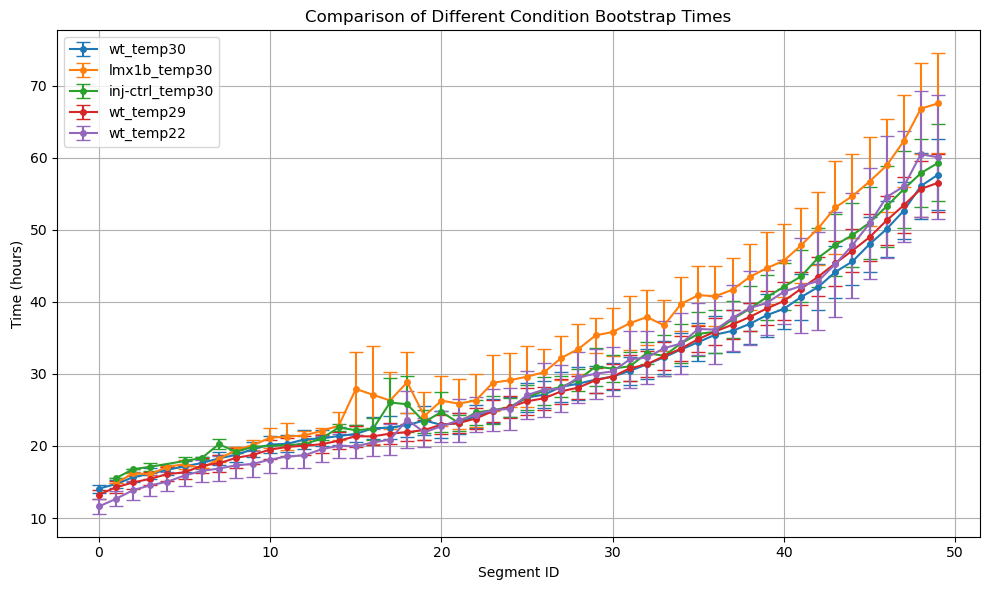

In [8]:
# Number of bootstrap journeys to run
num_journeys = 100  # Adjust based on computational resources

# Initialize lists to hold data and labels for the plot
data_list = []  # List of (summary_df, df_augmented) tuples
labels = []  # List of condition labels (phenotypes)

# Loop through each perturbation in pert_comparison
for pert in pert_comparisons:
    # Filter the augmented dataframe for the current phenotype
    print(pert)
    df_augmented_temp = df_augmented_projec_wt[df_augmented_projec_wt["phenotype"] == pert]

    # Run bootstrap journeys for the current phenotype
    journeys_df_temp = run_bootstrap_journeys(
        df_augmented=df_augmented_temp,  # Subset to perturbation you want to calculate spline for
        num_journeys=num_journeys,
        start_segment=0,
        end_segment=None,  # Defaults to max segment
        random_seed=42,
        time_column="experiment_time",
        segment_id_col="ref_seg_id"
    )

    # Compute the summary statistics (mean_time, std_time, etc.) for bootstrap journeys
    summary_df_temp =  summarize_journeys(journeys_df_temp)

    # Add summary_df and filtered augmented dataframe to the data list
    data_list.append((summary_df_temp, df_augmented_temp))

    # Add the current phenotype as a label
    labels.append(pert)


# Plot the comparison of bootstrap times across different conditions
plot_multi_bootstrap(
    data_list=data_list,
    labels=labels,
    title="Comparison of Different Condition Bootstrap Times",
    use_time_init=True  # Set to False if you don't want an offset
)


In [9]:
wt_30_spline = data_list[0][0]
wt_30_spline["mean_time_hours"] = (wt_30_spline["mean_time"] / (3600))
wt_30_spline

,segment_id,mean_time,std_time,count,mean_time_hours
0,0,1352.407217,1960.441626,177,0.375669
1,1,3640.715402,2095.461535,194,1.011310
2,2,7068.324301,2557.076168,174,1.963423
3,3,8793.147540,2699.478255,113,2.442541
4,4,10744.274575,2504.133904,93,2.984521
5,5,12451.850524,2800.337859,99,3.458847
6,6,14110.191947,3212.291871,89,3.919498
7,7,16419.010762,3427.260222,147,4.560836
8,8,18179.247107,3441.341008,126,5.049791
9,9,21051.560059,3749.615237,150,5.847656


/tmp/11629321.1.trapnell-login.q/ipykernel_2190593/2379988765.py:215: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/11629321.1.trapnell-login.q/ipykernel_2190593/2379988765.py:215: FutureWarning:



The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.



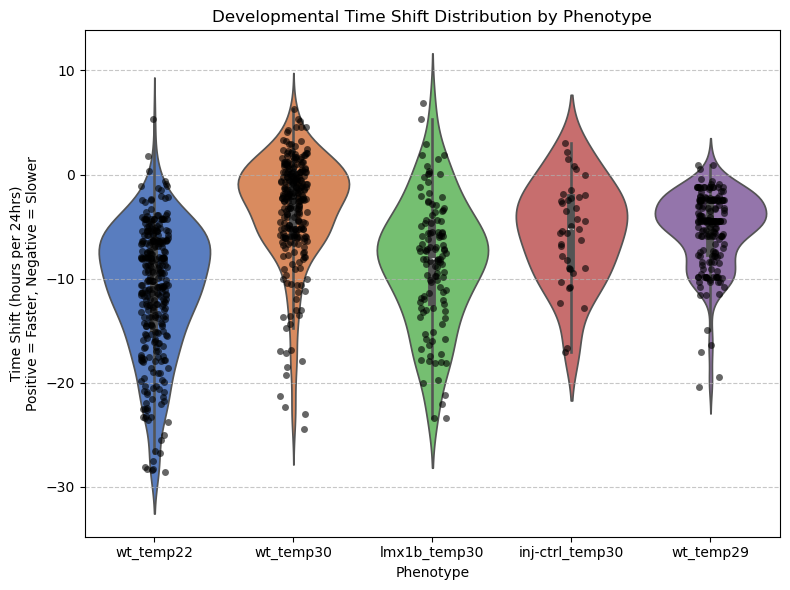

In [12]:
shift_df = compute_developmental_shifts(
    df_embryos=df_augmented_projec_wt,
    summary_df_wt_calc=wt_30_spline,
    color_by="phenotype"
)

plot_developmental_shifts_violin(shift_df, color_by="phenotype")

In [14]:
df_augmented_projec_wt

,Unnamed: 0,snip_id,embryo_id,experiment_time,experiment_date,temperature,medium,short_pert_name,control_flag,phenotype,...,ref_seg_id,closest_on_spline_x,closest_on_spline_y,closest_on_spline_z,plane_point_x,plane_point_y,plane_point_z,distance_to_plane,distance_to_axis,hypotenuse
0,28553,20231110_A08_e00_t0000,20231110_A08_e00,1919.332160,20231110,30,MC_015,wt_wik,0,wt_temp30,...,5,1.088146,2.158060,-0.852540,1.073893,2.288221,-0.898959,0.258528,0.143215,0.295545
1,28554,20231110_A08_e00_t0001,20231110_A08_e00,4951.991120,20231110,30,MC_015,wt_wik,0,wt_temp30,...,5,1.087534,2.158647,-0.850291,1.063635,2.350252,-0.904977,0.053883,0.206299,0.213219
2,28555,20231110_A08_e00_t0003,20231110_A08_e00,10012.480400,20231110,30,MC_015,wt_wik,0,wt_temp30,...,8,0.734972,2.289990,-0.153127,0.733971,2.317424,-0.167582,0.223110,0.035486,0.225915
3,28556,20231110_A08_e00_t0004,20231110_A08_e00,12550.292000,20231110,30,MC_015,wt_wik,0,wt_temp30,...,8,0.742100,2.288900,-0.162677,0.718308,2.425754,-0.202233,0.130329,0.144743,0.194772
4,28557,20231110_A08_e00_t0005,20231110_A08_e00,15075.814400,20231110,30,MC_015,wt_wik,0,wt_temp30,...,8,0.690488,2.296792,-0.093530,0.670925,2.390473,-0.122291,0.073107,0.141016,0.158840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55043,28094,20230629_F10_e00_t0019,20230629_F10_e00,50785.658936,20230629,22,MC_015,wt_wik,0,wt_temp22,...,22,-2.098214,0.784144,0.565105,-2.015849,0.769067,0.516441,0.314471,0.099774,0.329919
55044,28095,20230629_F10_e00_t0020,20230629_F10_e00,53513.303589,20230629,22,MC_015,wt_wik,0,wt_temp22,...,24,-2.180872,0.450566,0.331363,-2.144424,0.453268,0.324616,0.334460,0.117719,0.354572
55045,28096,20230629_F10_e00_t0021,20230629_F10_e00,56242.961914,20230629,22,MC_015,wt_wik,0,wt_temp22,...,23,-2.166264,0.549399,0.393413,-1.988581,0.549921,0.337626,0.597862,0.191816,0.627879
55046,28097,20230629_F10_e00_t0022,20230629_F10_e00,58975.074707,20230629,22,MC_015,wt_wik,0,wt_temp22,...,25,-2.180819,0.168226,0.184255,-1.982037,0.216234,0.167277,0.529390,0.220925,0.573639
